# Progetto ML Traccia A1: MedMNIST-Pneumonia - Filippo Muscherà (0338276)

## Goal

Lo scopo di questo progetto è quello di andare a modellare e addestrare alcuni modelli di ML, e compararli nel task di classificazione binaria del dataset MedMNIST-Pneumonia.
<br>
L'idea è quella di addestrare vari modelli, cercare di migliorarli e, infine, confrontarli per scegliere il migliore.

## Import e Utility Functions

Si raccolgono in questa cella tutti gli import necessari per il notebook.

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping
from keras.initializers import HeNormal
from tensorflow.keras.utils import plot_model
import pydot
from keras.preprocessing.image import ImageDataGenerator
import warnings
import seaborn as sns
from matplotlib.colors import Normalize
warnings.filterwarnings("ignore") # ignora un FutureWarning di Pandas
tf.random.set_seed(42)

Queste funzioni hanno lo scopo di leggere e scrivere da/su un file .csv utilizzato per salvare gli accuracy score e gli F1 score dei vari modelli. 

In [251]:
def add_result_to_csv(model_name, accuracy, file_name='results.csv'):
    # Check if the file exists
    file_exists = os.path.isfile(file_name)
    
    # If the file exists, read it into a DataFrame
    if file_exists:
        df = pd.read_csv(file_name)
    else:
        # If the file does not exist, create an empty DataFrame
        df = pd.DataFrame(columns=['Model', 'Value'])
    
    # Create a new DataFrame with the new result
    new_data = pd.DataFrame([[model_name, accuracy]], columns=['Model', 'Accuracy'])
    
    # Concatenate the existing DataFrame with the new data
    df = pd.concat([df, new_data], ignore_index=True)
    
    # Save the updated DataFrame to the CSV file
    df.to_csv(file_name, index=False)

In [6]:
def read_value_from_csv(model_name, csv_file_name='results.csv'):
    try:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(csv_file_name)

        # Find the accuracy corresponding to the model name
        accuracy = df.loc[df['Model'] == model_name, 'Value'].values[0]

        return accuracy
    
    except FileNotFoundError:
        print(f"File '{csv_file_name}' not found.")
        return None
    except IndexError:
        print(f"Model '{model_name}' not found in file '{csv_file_name}'.")
        return None

In [4]:
# Controlla le GPU disponibili
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Numero di GPU disponibili: {len(gpus)}")
    for gpu in gpus:
        print(f"Nome GPU: {gpu.name}")
else:
    print("Nessuna GPU disponibile")

Numero di GPU disponibili: 1
Nome GPU: /physical_device:GPU:0


## Import e Pre-processamento Dataset

Si procede al caricamento del dataset. Il dataset viene poi inizialmente suddiviso in train e test set. Per questa suddivisione su utilizza un seed in modo che l'operazione sia ripetibile per run diverese del notebook.
<br>
Il dataset contiene 5232 esempi. Si sceglie di avere un testing set con una size pari al 10% della size ttoale del dataset.

In [5]:
x = np.load(r"C:\Users\filip\Desktop\Filippo\Uni\Magistrale\ML\pneumonia_images.npy")
y = np.load(r"C:\Users\filip\Desktop\Filippo\Uni\Magistrale\ML\pneumonia_labels.npy")

#creazione dei vari dataset
seed = 1999
#separazione train e test set
train_images, test_images = train_test_split(x, test_size=0.1, random_state=seed)
train_labels, test_labels = train_test_split(y, test_size=0.1, random_state=seed)

print("Numero di immagini totale = ", len(x))
print("Numero di immagini nel testing set = ", len(test_images))

Numero di immagini totale =  5232
Numero di immagini nel testing set =  524


Le "train_images" vengono suddivise ulteriormente in training set e validation set. Questo viene fatto allo scopo di utilizzare il validation set per il tuining degli iper-parametri, in modo da utilizzare il testing set solo alla fine, per valutare le prestazioni del modello ottenuto su un dataset che non ha mai visto in precedenza.
<br>
Il training set viene realizzato in modo da comprendere l'80% degli esempi del dataset a cui era stato già rimosso il testing set. Il rimanente verrà utilizzato come valdiation set.
<br>
Le immagini, come da best-practice, vengono anche normalizzate. 

In [6]:
# creazione validation set e train set con split 80/20 a favore del training set
x_valid_images = train_images[3765:]/255. # normalizzazione
x_valid_labels = train_labels[3765:]
x_train_images = train_images[:3765]/255. # normalizzazione
x_train_labels = train_labels[:3765]

#normalizzazione test set
test_images = test_images/255.

print("Numero di immagini nel training set = ", len(x_train_images))
print("Numero di immagini nel validation set = ", len(x_valid_images))

Numero di immagini nel training set =  3765
Numero di immagini nel validation set =  943


Si va ora ad osservare alcune immagini del dataset.

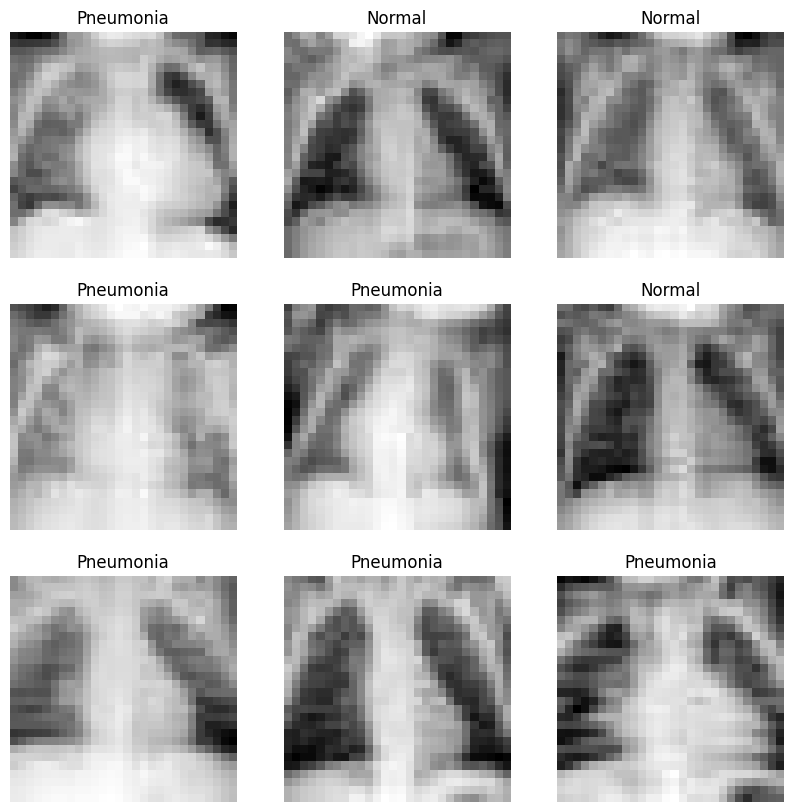

In [14]:
plt.figure(figsize=(10, 10))
for i in range(0, 9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train_images[i], cmap='gray')
    label = 'Normal' if  x_train_labels[i] == 0 else 'Pneumonia'
    plt.title(label)
    plt.axis("off")

Prima di passare ai modelli, si decide anche di osservare la distribuzione delle due classi nel dataset.

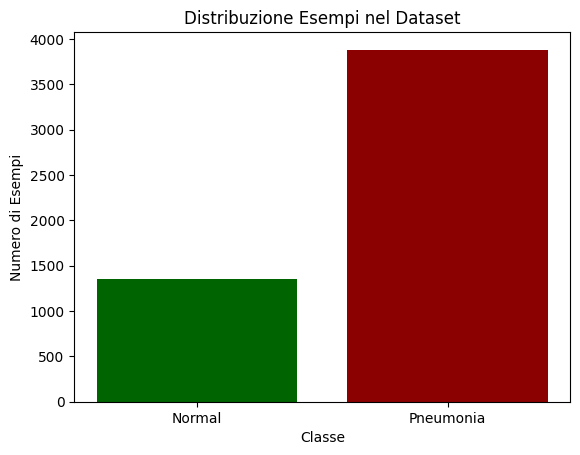

In [17]:
# Conta le occorrenze di ciascuna etichetta
unique, counts = np.unique(y, return_counts=True)
labels_counts = dict(zip(unique, counts))

# Crea il grafico a colonne
fig, ax = plt.subplots()
ax.bar(labels_counts.keys(), labels_counts.values(), color=['darkgreen', 'darkred'])

# Imposta i titoli e le etichette
ax.set_xlabel('Classe')
ax.set_ylabel('Numero di Esempi')
ax.set_title('Distribuzione Esempi nel Dataset')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Normal', 'Pneumonia'])

# Mostra il grafico
plt.show()


Si può notare come il dataset sia abbastanza sbilanciato: Le immagini della classe "Pneumonia" (label = 1) sono quasi il triplo rispetto a quelle dell'altra classe. 

## Random Forest

Il primo modello che si va a definire è quello di Random Forest. Questo modello spesso viene utilizzato, con buoni risultati, in maniera black box. Si sceglie perrtanto di partire con questo modello anche per fornire una base-line a tutti i successivi modelli. 
<br>
Si utilizza una grid search per cercare di ottenere il miglior albero tra tutti quelli considerati. 

In [264]:
x_train_flat = x_train_images.reshape(x_train_images.shape[0], -1)
x_valid_flat = x_valid_images.reshape(x_valid_images.shape[0], -1)
test_flat = test_images.reshape(test_images.shape[0], -1)

# Creazione del modello di Random Forest
rf = RandomForestClassifier(random_state=42) # seed per rendere l'esecuzione ripetibile

# Definizione della griglia degli iperparametri
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False]
}

# Creazione della grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)

# Addestramento della grid search
grid_search.fit(x_train_flat, x_train_labels.ravel()) # circa 10 minuti per la grid search

# Migliori iperparametri trovati
print("Best parameters found: ", grid_search.best_params_)

# Valutazione del modello sul validation set
best_rf = grid_search.best_estimator_
valid_predictions = best_rf.predict(x_valid_flat)
accuracy = accuracy_score(x_valid_labels.ravel(), valid_predictions)
print("Validation set accuracy: ", accuracy)

# Valutazione finale sul test set
test_predictions = best_rf.predict(test_flat)
test_accuracy_random_forest = accuracy_score(test_labels.ravel(), test_predictions)
print("Test set accuracy: ", test_accuracy_random_forest)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters found:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Validation set accuracy:  0.95864262990456
Test set accuracy:  0.9599236641221374


Il miglior modello trovato tramite la grid search utilizza 200 alberi, e ha come criterio per la scelta del miglior split 'Entropy', che corrisponde quindi all'Information Gain. Da notare anche come questo modello non utilizzi il bootstrapping, e quindi gli alberi del Random Forest sono costruiti tutti a partire dallo stesso identico dataset. 
<br>
Il modello migliore ha una accuracy sul testing set che sfiora il 96%.
<br>
Da notare come in questo caso il validation set non venga utilizzato durante il training perché viene utilizzata la cross-validation. Si sarebbe anche potuto scegliere quindi di unire training set e validation set in questo caso, visto l'utilizzo della cross validation. Tuttavia si è scelto di non farlo per poter confrotare i vari modelli in maniera più 'fair' possibile, utilizzando lo stesso training set per tutti. 

In [302]:
# Calcolo della confusion matrix sul test set
cm_rf = confusion_matrix(test_labels.ravel(), test_predictions)

# Calcolo dell'F1 score sul test set
f1_rf = f1_score(test_labels.ravel(), test_predictions)

In [267]:
add_result_to_csv('Random Forest', test_accuracy_random_forest) # aggiunta entry per RF nel .csv
add_result_to_csv('Random Forest', f1_rf, 'f1.csv')

In [269]:
report_test = classification_report(test_labels.ravel(), best_rf.predict(test_flat))
print(report_test)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       132
           1       0.97      0.97      0.97       392

    accuracy                           0.96       524
   macro avg       0.95      0.95      0.95       524
weighted avg       0.96      0.96      0.96       524



## Regressione Logistica

Il secondo modello considerato per la classificazione binaria è quello della regressione logistica. Anche in questo caso si è utilizzata una grid search. In particolare, in questo caso, è stata realizzata per provare tutti i solver con tutte le possibili tecniche di penalty per la regolarizzazione. 

In [270]:
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(random_state=42, max_iter=100))
])

# Definizione della griglia degli iperparametri per la regressione logistica
param_grid_logreg = [
    {'logreg__C': [0.01, 0.1, 1, 10, 100], # termine per la regolarizzazione. Più è piccolo più è forte 
     'logreg__solver': ['liblinear'],
     'logreg__penalty': ['l1', 'l2']},
    {'logreg__C': [0.01, 0.1, 1, 10, 100],
     'logreg__solver': ['saga'],
     'logreg__penalty': ['l1', 'l2', 'elasticnet'],
     'logreg__l1_ratio': [0.5]},  # l1_ratio è richiesto per elasticnet
    {'logreg__C': [0.01, 0.1, 1, 10, 100],
     'logreg__solver': ['newton-cg', 'lbfgs', 'sag', 'newton-cholesky'],
     'logreg__penalty': ['l2']}
]
# Creazione della grid search
grid_search_logreg = GridSearchCV(estimator=pipe, param_grid=param_grid_logreg, cv=3, n_jobs=-1, verbose=3)

In [271]:
# Addestramento della grid search
grid_search_logreg.fit(x_train_flat, x_train_labels.ravel())

# Migliori iperparametri trovati
print("Best parameters found for Logistic Regression: ", grid_search_logreg.best_params_)

# Valutazione del modello sul validation set
best_logreg = grid_search_logreg.best_estimator_
valid_predictions_logreg = best_logreg.predict(x_valid_flat)
accuracy_logreg = accuracy_score(x_valid_labels.ravel(), valid_predictions_logreg)
print("Validation set accuracy for Logistic Regression: ", accuracy_logreg)

# Valutazione finale sul test set
test_predictions_logreg = best_logreg.predict(test_flat)
test_accuracy_logreg = accuracy_score(test_labels.ravel(), test_predictions_logreg)
print("Test set accuracy for Logistic Regression: ", test_accuracy_logreg)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best parameters found for Logistic Regression:  {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'sag'}
Validation set accuracy for Logistic Regression:  0.9618239660657476
Test set accuracy for Logistic Regression:  0.9675572519083969


La grid search ci restituisce il miglior modello tra quelli testati. Questo modello si dimostra già migliore del Random Forest per quanto riguarda l'accuracy, che raggiunge il 96.75%. 

In [272]:
# Calcolo della confusion matrix sul test set
cm_logreg = confusion_matrix(test_labels.ravel(), test_predictions_logreg)

# Calcolo dell'F1 score sul test set
f1_logreg = f1_score(test_labels.ravel(), test_predictions_logreg)

In [273]:
add_result_to_csv('Logistic Regression', test_accuracy_logreg)
add_result_to_csv('Logistic Regression', f1_logreg, 'f1.csv')


In [274]:
report_test_logreg = classification_report(test_labels.ravel(), test_predictions_logreg)
print(report_test_logreg)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       132
           1       0.98      0.97      0.98       392

    accuracy                           0.97       524
   macro avg       0.95      0.96      0.96       524
weighted avg       0.97      0.97      0.97       524



Anche l'F1 score della Regressione logistica è migliore di quello di Random Forest, sia nella macro abg (non pesata sulla classi) che nella weighted avg, dove invece viene pesata sulla distribuzione delle classi.  

## CNN

Il prossimo modello che si va a realizzare è una rete neurale. In particolare, dato che il dataset è composto da immagini, si decide di utilizzare direttamente una **CNN**.
<br>
Sarebbe infatti possibile anche utilizzare una DNN, ma si avrebbero due svantaggi. Non si potrebbero sfruttare le informazioni che potenzialmente possono fornire pixel che si trovano adiacenti, perché le immagini andrebbero vettorizzate e si perderebbe la loro rappresentazione come matrice/griglia. Inoltre, avendo solamente livelli completamente connessi, si andrebbe ad avere un numero di parametri ben più alto a parità di livelli. Risulterebbe quindi anche più lungo il processo di addestramento della rete.
<br>
<br>
Questa CNN è stata realizzata ispirandosi a *LeNet*, alternando dunque livelli di convoluzione e livelli di pooling. Si sono poi aggiunti in coda dei livelli densi per la classificazione delle immagini a effettuata utilizzando le feature estratte dai filtri dei livelli convoluzionali. 
<br>
Per evitare di rendere il notebook eccessivamente lungo si è riportata in questa versione finale direttamente la versione che ha mostrato le migliori performance. In particolare, si sono provati diversi valori per il numero di filtri e la loro dimensione. Inoltre si è visto che, per questa rete, l'utilizzo dell'average pooling produce risultati migliori rispetto al max pooling. 
<br>
Essendo questa la prima CNN realizzata, si è scelto di realizzare un modello relativamente semplice per osservarne le prestazioni. Si è inoltre visto che l'aggiunta di ulteriori layer densi o l'impiego di layer densi con un numero più alto di hidden units non portava a miglioramenti sull'accuracy, ma solo a tempi di addestramento più lunghi. 
<br>
<br>
Per l'addestramento l'optimizer migliore si è dimostrato essere ADAM. Si è utilizzato un numero di epoche relativamente alto (300), con la consapevolezza che si è definita anche una callback per l'early stopping. In questo modo, anche se il numero di epoche dovesse essere eccessivo e potrebbe portare il modello in overfitting, si avrà l'early stopping a fermare l'addestramento e ripristinare i parametri dell'epoca migliore.

In [31]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

x_reshaped_train = x_train_images.reshape(-1,28,28,1)
x_reshaped_valid = x_valid_images.reshape(-1,28,28,1)
test_reshaped = test_images.reshape(-1,28,28,1)

init = keras.initializers.HeNormal(seed=42) # best for ReLu
con_init = keras.initializers.GlorotUniform(seed=42) # default ma con seed fissato per ripetibilità 

CNN_lenet = Sequential([
    Conv2D(10, kernel_size=(5, 5), activation='relu',padding='same',input_shape=(28,28,1), kernel_initializer=con_init),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Conv2D(20, kernel_size=(5, 5), activation='relu', kernel_initializer=con_init),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=init),
    Dense(128, activation='relu', kernel_initializer=init),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


CNN_lenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn_lenet = CNN_lenet.fit(x_reshaped_train, x_train_labels, epochs=300, validation_data=(x_reshaped_valid, x_valid_labels), callbacks=[early_stopping])


Epoch 1/300
118/118 [==============================] - 2s 9ms/step - loss: 0.3157 - accuracy: 0.8598 - val_loss: 0.2087 - val_accuracy: 0.9088
Epoch 2/300
118/118 [==============================] - 1s 6ms/step - loss: 0.1893 - accuracy: 0.9227 - val_loss: 0.1783 - val_accuracy: 0.9247
Epoch 3/300
118/118 [==============================] - 1s 7ms/step - loss: 0.1620 - accuracy: 0.9331 - val_loss: 0.1294 - val_accuracy: 0.9533
Epoch 4/300
118/118 [==============================] - 1s 6ms/step - loss: 0.1519 - accuracy: 0.9378 - val_loss: 0.1269 - val_accuracy: 0.9470
Epoch 5/300
118/118 [==============================] - 1s 8ms/step - loss: 0.1511 - accuracy: 0.9413 - val_loss: 0.1568 - val_accuracy: 0.9343
Epoch 6/300
118/118 [==============================] - 1s 6ms/step - loss: 0.1406 - accuracy: 0.9450 - val_loss: 0.2031 - val_accuracy: 0.9141
Epoch 7/300
118/118 [==============================] - 1s 7ms/step - loss: 0.1228 - accuracy: 0.9556 - val_loss: 0.1010 - val_accuracy: 0.9586

In [176]:
#test set
cnn_lenet_loss, cnn_lenet_accuracy = CNN_lenet.evaluate(test_reshaped, test_labels)
print('CNN_lenet_accuracy over test set = ', cnn_lenet_accuracy)

y_pred_probs = cnn_inception_extended.predict(test_images)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_labels.flatten()

# Calcolare l'F1 Score
f1_cnn_lenet = f1_score(y_true, y_pred)
print(f'F1 Score: {f1_cnn_lenet}')

# Calcolare la Confusion Matrix
cm_cnn_lenet = confusion_matrix(y_true, y_pred)

17/17 [==============================] - 0s 4ms/step - loss: 0.0889 - accuracy: 0.9714
CNN_lenet_accuracy over test set =  0.9713740348815918
F1 Score: 0.9833546734955185


L'early stopping ferma l'aggiornamento dopo poco più di 30 eopche. Essendo questa una CNN abbastanza semplice era prevedibile che l'addestramento avrebbe richiesto un numero di epoche abbastanza ridotto.
<br>
L'accuracy di questo modello sul testing set è di poco superiore al 97%, e quindi rappresenta già un ulteriore miglioramento rispetto alla Regressione Logistica. 

In [254]:
add_result_to_csv('CNN LeNet', cnn_lenet_accuracy)
add_result_to_csv('CNN LeNet', f1_cnn_lenet, 'f1.csv')
CNN_lenet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 10)        260       
_________________________________________________________________
average_pooling2d_10 (Averag (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 20)        5020      
_________________________________________________________________
average_pooling2d_11 (Averag (None, 5, 5, 20)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_16 (Dense)             (None, 128)              

Infine andiamo ad osservare la struttura di questa CNN. Qui si nota come il numero di parametri relativi ai due livelli densi vada a costituire quasi il 97% dei parametri totali.

### CNN + Dropout

Con l'obiettivo di avere un modello che generalizzi meglio su dati che non ha mai visto in precedenza si sceglie di inserire nella CNN appena definita dei livelli di Dropout. 
<br>
Il dropout è stato inserito sia per i livelli densi, sia dopo i livelli di pooling. I valori migliori si sono rivelati 0.35 per i livelli di Pooling e 0.7 per quelli Dense.

In [204]:
x_reshaped_train = x_train_images.reshape(-1,28,28,1)
x_reshaped_valid = x_valid_images.reshape(-1,28,28,1)
test_reshaped = test_images.reshape(-1,28,28,1)

init = keras.initializers.HeNormal(seed=42)

CNN_lenet_opt = Sequential([
    Conv2D(10, kernel_size=(5, 5), activation='relu',padding='same',input_shape=(28,28,1)),
    AveragePooling2D(pool_size=(2, 2),strides=2),        
    Dropout(0.35),
    Conv2D(20, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.35),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=init),
    Dropout(0.7),
    Dense(128, activation='relu', kernel_initializer=init),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


CNN_lenet_opt.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn_lenet = CNN_lenet_opt.fit(x_reshaped_train, x_train_labels, epochs=300, validation_data=(x_reshaped_valid, x_valid_labels), callbacks=[early_stopping])

Epoch 1/300
118/118 [==============================] - 1s 6ms/step - loss: 0.5684 - accuracy: 0.7307 - val_loss: 0.4533 - val_accuracy: 0.8028
Epoch 2/300
118/118 [==============================] - 1s 5ms/step - loss: 0.3484 - accuracy: 0.8375 - val_loss: 0.2557 - val_accuracy: 0.8908
Epoch 3/300
118/118 [==============================] - 0s 4ms/step - loss: 0.2709 - accuracy: 0.8903 - val_loss: 0.1768 - val_accuracy: 0.9353
Epoch 4/300
118/118 [==============================] - 1s 5ms/step - loss: 0.2461 - accuracy: 0.9017 - val_loss: 0.1629 - val_accuracy: 0.9385
Epoch 5/300
118/118 [==============================] - 1s 5ms/step - loss: 0.2190 - accuracy: 0.9134 - val_loss: 0.1403 - val_accuracy: 0.9470
Epoch 6/300
118/118 [==============================] - 1s 5ms/step - loss: 0.2147 - accuracy: 0.9155 - val_loss: 0.1987 - val_accuracy: 0.9109
Epoch 7/300
118/118 [==============================] - 1s 5ms/step - loss: 0.1946 - accuracy: 0.9264 - val_loss: 0.1131 - val_accuracy: 0.9544

In [206]:
#test set
CNN_lenet_opt_loss, CNN_lenet_opt_accuracy = CNN_lenet_opt.evaluate(test_reshaped, test_labels)
print('CNN_lenet_opt_accuracy over test set = ', CNN_lenet_opt_accuracy)

y_pred_probs2 = CNN_lenet_opt.predict(test_reshaped)
y_pred2 = (y_pred_probs2 > 0.5).astype(int).flatten()
y_true2 = test_labels.flatten()

# Calcolare l'F1 Score
f1_cnn_lenet_opt = f1_score(y_true2, y_pred2)
print(f'F1 Score: {f1_cnn_lenet_opt}')

# Calcolare la Confusion Matrix
cm_cnn_lenet_opt = confusion_matrix(y_true2, y_pred2)

17/17 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.9809
CNN_lenet_opt_accuracy over test set =  0.9809160232543945
F1 Score: 0.9872122762148338


Dopo aver eseguito il training della rete neurale, si analizzano i risultati ottenuti sul testing set. 
<br>
Si nota subito un miglioramento dell'accuracy: la CNN con il Dropout riesce a generalizzare meglio le relazioni sui dati, e ottiene un'accuracy poco superioire al 98% sui dati del testing set. 

In [255]:
add_result_to_csv('CNN LeNet Dropout', CNN_lenet_opt_accuracy)
add_result_to_csv('CNN LeNet Dropout', f1_cnn_lenet_opt, 'f1.csv')
CNN_lenet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 10)        260       
_________________________________________________________________
average_pooling2d_10 (Averag (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 20)        5020      
_________________________________________________________________
average_pooling2d_11 (Averag (None, 5, 5, 20)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_16 (Dense)             (None, 128)              

La struttura del modello è quindi rimasta invariata, ma riesce a generalizzare meglio grazie all'utilizzo del Dropout.

### CNN + Dropout + Batch Normalization

Come ulteriore possibile miglioramento per questo modello si è andati ad utilizzare la Batch Normalization.

In [66]:
# Reshape dei dati di input
x_reshaped_train = x_train_images.reshape(-1, 28, 28, 1)
x_reshaped_valid = x_valid_images.reshape(-1, 28, 28, 1)
test_reshaped = test_images.reshape(-1, 28, 28, 1)

# Inizializzazione dei pesi
init = HeNormal(seed=42)

# Costruzione della rete con batch normalization
CNN_lenet_opt_bn = Sequential([
    Conv2D(10, kernel_size=(5, 5), padding='same', input_shape=(28, 28, 1)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.35),

    Conv2D(20, kernel_size=(5, 5)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.35),

    Flatten(),

    Dense(256, kernel_initializer=init),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.7),

    Dense(128, kernel_initializer=init),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.7),

    Dense(1, activation='sigmoid')
])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compilazione del modello
CNN_lenet_opt_bn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento del modello
history_cnn_lenet_bn = CNN_lenet_opt_bn.fit(x_reshaped_train, x_train_labels, epochs=300, validation_data=(x_reshaped_valid, x_valid_labels), callbacks=[early_stopping])


Epoch 1/300
118/118 [==============================] - 2s 9ms/step - loss: 0.5055 - accuracy: 0.7641 - val_loss: 0.4862 - val_accuracy: 0.7487
Epoch 2/300
118/118 [==============================] - 1s 6ms/step - loss: 0.2915 - accuracy: 0.8784 - val_loss: 0.4209 - val_accuracy: 0.7572
Epoch 3/300
118/118 [==============================] - 1s 7ms/step - loss: 0.2552 - accuracy: 0.8956 - val_loss: 0.1961 - val_accuracy: 0.9332
Epoch 4/300
118/118 [==============================] - 1s 7ms/step - loss: 0.2349 - accuracy: 0.9084 - val_loss: 0.2177 - val_accuracy: 0.9120
Epoch 5/300
118/118 [==============================] - 1s 7ms/step - loss: 0.2111 - accuracy: 0.9171 - val_loss: 0.1816 - val_accuracy: 0.9215
Epoch 6/300
118/118 [==============================] - 1s 7ms/step - loss: 0.1939 - accuracy: 0.9243 - val_loss: 0.1588 - val_accuracy: 0.9321
Epoch 7/300
118/118 [==============================] - 1s 7ms/step - loss: 0.1840 - accuracy: 0.9293 - val_loss: 0.1142 - val_accuracy: 0.9586

Con l'impiego della Batch Normalization notiamo come l'addestramento sia più rapido sia del modello "base" della CNN, sia del caso con il Dropout.
<br>
In questo caso infatti l'Early Stopping subentra dopo appena 28 epoche, contro le 34 e 43 delle versioni precedenti della CNN. 

In [179]:
#test set
CNN_lenet_opt_bn_loss, CNN_lenet_opt_bn_acc = CNN_lenet_opt_bn.evaluate(test_reshaped, test_labels)
print('CNN_lenet_opt_bn_accuracy over test set = ', CNN_lenet_opt_bn_acc)

y_pred_probs3 = CNN_lenet_opt_bn.predict(test_reshaped)
y_pred3 = (y_pred_probs3 > 0.5).astype(int).flatten()
y_true3 = test_labels.flatten()

# Calcolare l'F1 Score
f1_cnn_lenet_opt_bn = f1_score(y_true3, y_pred3)
print(f'F1 Score: {f1_cnn_lenet_opt_bn}')

# Calcolare la Confusion Matrix
cm_cnn_lenet_opt_bn = confusion_matrix(y_true3, y_pred3)

17/17 [==============================] - 0s 4ms/step - loss: 0.0860 - accuracy: 0.9752
CNN_lenet_opt_bn_accuracy over test set =  0.9751908183097839
F1 Score: 0.9833971902937421


Questa terza evoluzione della CNN tuttavia non comporta un miglioramento dell'accuracy rispetto al testing set. 
<br>
Si è provato ad utilizzare la batch normalization sia con il dropout che senza. Si è anche provato ad usarla solo per i livelli densi o solo per quelli convoluzionali. Alla fine la versione che ha portato ai migliori risultati è stata quella riportata in questo notebook. 

In [256]:
add_result_to_csv('CNN LeNet Dropout and BN', CNN_lenet_opt_bn_acc)
add_result_to_csv('CNN LeNet Dropout and BN', f1_cnn_lenet_opt_bn, 'f1.csv')
CNN_lenet_opt_bn.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 28, 28, 10)        260       
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 10)        40        
_________________________________________________________________
activation_20 (Activation)   (None, 28, 28, 10)        0         
_________________________________________________________________
average_pooling2d_42 (Averag (None, 14, 14, 10)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 10, 10, 20)        5020      
_________________________________________________________________
batch_normalization_21 (Batc (None, 10, 10, 20)      

Il numero di parametri cresce leggermente a causa dei nuovi parametri per la Batch Normalization, ma resta del tutto simile a quello delle precedenti versioni della CNN.
<br>
<br>
In conclusione, la miglior versione di questa CNN si è dimostrata essere la sua versione con l'impiego del Dropout.

## CNN con blocco Inception

Per questo nuovo modello si è scelto di utilizzare nuovamente una CNN, stavolta però ispirandosi a GoogLeNet. In particolare si è pensato di creare una rete più complessa della precedente, e cercare di andare a creare un blocco simile a quello Inception, in cui concatenare l'output di vari branch convoluzionali, su cui andare ad utilizzare kernel e/o pooling con dimensioni diverse.
<br>
Per quanto riguarda il blocco ispirato a quello Inception, sono stati utilizzati filtri di dimensioni diverse. Si è ripetuto l'addestramento più volte, alla ricerca delle migliori dimensioni per i kernel. La rete ha mostrato di riuscire a produrre i risultati migliori con l'utilizzo di filtri più grandi rispetto a quelli del Inception block "standard". 

In [2]:
# Funzione per creare un blocco Inception
def single_inception_block(x, filters):
    layers = tf.keras.layers
    # Branch 1: Convolution
    branch1 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
    
    # Branch 2: Convolution followed by Convolution
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (7, 7), padding='same', activation='relu')(branch2)
    
    # Branch 3: Convolution followed by Convolution
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
    branch3 = layers.Conv2D(filters, (11, 11), padding='same', activation='relu')(branch3)
    
    # Branch 4: 3x3 MaxPooling followed by Convolution
    branch4 = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch4)
    
    # Concatenate all branches
    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

# Costruzione del modello
def create_single_inception_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    layers = tf.keras.layers

    
    # blocco Inception
    x = single_inception_block(inputs, 64)
    
    # Global Average Pooling per ridurre la dimensionalità
    x = layers.GlobalAveragePooling2D()(x)
    # livelli densi per la classificazione
    init = keras.initializers.HeNormal(seed=42)

    x = layers.Dense(256, activation='relu', kernel_initializer=init)(x)
    x = Dropout(0.6) (x)

    x = layers.Dense(128, activation='relu', kernel_initializer=init)(x)
    x = Dropout(0.6) (x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

input_shape = (28, 28, 1)
CNN_single_inception = create_single_inception_cnn(input_shape)

# Compilazione del modello
CNN_single_inception.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Riassunto del modello
CNN_single_inception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 28, 28, 1)    0           input_1[0][0]                    
______________________________________________________________________________________________

Questa prima versione della CNN con un singolo blocco inception, seguito poi da 3 layer densi, presenta un numero di parametri notevolmente più alto della CNN ispirata a LeNet.  

In [240]:
# Creazione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Addestramento del modello
history_single_inception = CNN_single_inception.fit(x_train_images, x_train_labels, epochs=300,
                    verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[early_stopping])



Epoch 1/300
118/118 [==============================] - 3s 16ms/step - loss: 0.5676 - accuracy: 0.7389 - val_loss: 0.5259 - val_accuracy: 0.7487
Epoch 2/300
118/118 [==============================] - 2s 15ms/step - loss: 0.4567 - accuracy: 0.7764 - val_loss: 0.3571 - val_accuracy: 0.8335
Epoch 3/300
118/118 [==============================] - 2s 15ms/step - loss: 0.3580 - accuracy: 0.8470 - val_loss: 0.2271 - val_accuracy: 0.9003
Epoch 4/300
118/118 [==============================] - 2s 15ms/step - loss: 0.2777 - accuracy: 0.8866 - val_loss: 0.1959 - val_accuracy: 0.9247
Epoch 5/300
118/118 [==============================] - 2s 15ms/step - loss: 0.2129 - accuracy: 0.9137 - val_loss: 0.1978 - val_accuracy: 0.9194
Epoch 6/300
118/118 [==============================] - 2s 15ms/step - loss: 0.1924 - accuracy: 0.9254 - val_loss: 0.1261 - val_accuracy: 0.9565
Epoch 7/300
118/118 [==============================] - 2s 15ms/step - loss: 0.1869 - accuracy: 0.9264 - val_loss: 0.1576 - val_accuracy:

Avendo un numero molto più alto di parametri, il training di questa rete si è dimostrato più lungo sia come numero di epoche necessarie prima dell'intervento dell'early stopping, sia come tempo di addestramento per ogni epoca. 

In [241]:
CNN_single_inception_loss, CNN_single_inception_acc = CNN_single_inception.evaluate(test_images, test_labels)
print('CNN_single_inception_accuracy over test set = ', CNN_single_inception_acc)


y_pred_probs4 = CNN_single_inception.predict(test_reshaped)
y_pred4 = (y_pred_probs4 > 0.5).astype(int).flatten()
y_true4 = test_labels.flatten()

# Calcolare l'F1 Score
f1_cnn_single_inception = f1_score(y_true4, y_pred4)
print(f'F1 Score: {f1_cnn_single_inception}')

# Calcolare la Confusion Matrix
cm_cnn_single_inception = confusion_matrix(y_true4, y_pred4)

17/17 [==============================] - 0s 5ms/step - loss: 0.0684 - accuracy: 0.9771
CNN_single_inception_accuracy over test set =  0.9770992398262024
F1 Score: 0.9845758354755784


I risultati ottenuti sul testing set non superano quelli della miglior versione precedente della CNN ispirata a LeNet, ma ci si avvicinano molto, arrivando ad avere un 97.7% di accuracy.

In [257]:
add_result_to_csv('CNN Single Inception', CNN_single_inception_acc)
add_result_to_csv('CNN Single Inception', f1_cnn_single_inception, 'f1.csv')

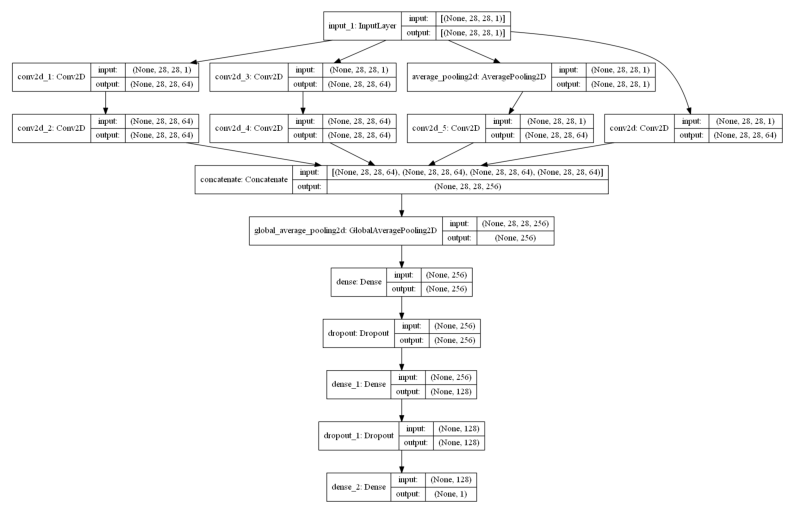

In [3]:
# Visualizzazione della struttura del modello
plot_model(CNN_single_inception, to_file='model_structure_single.png', show_shapes=True, show_layer_names=True)

# Mostra l'immagine della struttura del modello
img = plt.imread('model_structure_single.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

Si riporta anche una visualizzazione grafica del modello corrente: l'input viene inviato in parallelo ai quattro branch. Ognuno di essi applica filtri o pooling di dimensioni diverse, e poi i risultaiti vengono concatenati tra di loro. 

## CNN con blocchi Inception Concatenati

Si realizza anche una seconda versione di questa rete, cercando di complicare ulteriormente il modello, per vedere se un numero più alto di parametri aiuta la rete nel trovare nuove relazioni tra i dati, e quindi generalizzare meglio il dataset.
<br>
Per farlo si sceglie di estendere la struttura della CNN precedente andando a inserire in sequenza più blocchi Inception, prima di passare alla parte con layer densi della rete.

In [142]:
# Funzione per creare un blocco Inception
def inception_module(x, filters):
    layers = tf.keras.layers
    # Branch 1: 1x1 Convolution
    branch1 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
    
    # Branch 2: 1x1 Convolution followed by 3x3 Convolution
    branch2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    branch2 = layers.Conv2D(filters, (7, 7), padding='same', activation='relu')(branch2)
    
    # Branch 3: 1x1 Convolution followed by 5x5 Convolution
    branch3 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
    branch3 = layers.Conv2D(filters, (11, 11), padding='same', activation='relu')(branch3)
    
    # Branch 4: 3x3 MaxPooling followed by 1x1 Convolution
    branch4 = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(branch4)
    
    # Concatenate all branches
    output = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output
# Costruzione del modello
def create_inception_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    layers = tf.keras.layers

    # Primo blocco Inception
    x = inception_module(inputs, 32)

    # Secondo blocco Inception
    x = inception_module(x, 64)

    # Terzo blocco Inception
    x = inception_module(x, 128)

    # Aggiunta di un Global Average Pooling per ridurre la dimensionalità
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

# Creazione del modello con input shape (28, 28, 1) per immagini in scala di grigi
input_shape = (28, 28, 1)
cnn_inception_extended = create_inception_cnn(input_shape)

# Compilazione del modello
cnn_inception_extended.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Riassunto del modello
cnn_inception_extended.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_256 (Conv2D)             (None, 28, 28, 32)   320         input_26[0][0]                   
__________________________________________________________________________________________________
conv2d_258 (Conv2D)             (None, 28, 28, 32)   832         input_26[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_70 (AveragePo (None, 28, 28, 1)    0           input_26[0][0]                   
___________________________________________________________________________________________

In [143]:
# Creazione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Addestramento del modello
history = cnn_inception_extended.fit(x_train_images, x_train_labels, epochs=300,
                    verbose=1,
                    validation_data=(x_valid_images, x_valid_labels),
                    callbacks=[early_stopping])


Epoch 1/300
118/118 [==============================] - 11s 76ms/step - loss: 0.5532 - accuracy: 0.7389 - val_loss: 0.3962 - val_accuracy: 0.8324
Epoch 2/300
118/118 [==============================] - 9s 74ms/step - loss: 0.3469 - accuracy: 0.8444 - val_loss: 0.2118 - val_accuracy: 0.9162
Epoch 3/300
118/118 [==============================] - 9s 74ms/step - loss: 0.2529 - accuracy: 0.8993 - val_loss: 0.2253 - val_accuracy: 0.9332
Epoch 4/300
118/118 [==============================] - 9s 74ms/step - loss: 0.2001 - accuracy: 0.9230 - val_loss: 0.1388 - val_accuracy: 0.9480
Epoch 5/300
118/118 [==============================] - 9s 74ms/step - loss: 0.1708 - accuracy: 0.9317 - val_loss: 0.1387 - val_accuracy: 0.9523
Epoch 6/300
118/118 [==============================] - 9s 75ms/step - loss: 0.1611 - accuracy: 0.9357 - val_loss: 0.1598 - val_accuracy: 0.9290
Epoch 7/300
118/118 [==============================] - 9s 74ms/step - loss: 0.1662 - accuracy: 0.9336 - val_loss: 0.1323 - val_accuracy

Dato l'altissimo numero di parametri di questa rete rispetto a quelle precedenti, il suo training è estramemente più lento. Sulla macchina utilizzata per realizzare questo notebook, infatti, ogni epoca per l'addestramento di questa rete ha impiegato circa 9 secondi, contro i 2 secondi per epoca della rete precedente. 

In [244]:
_ , cnn_inception_extended_accuracy = cnn_inception_extended.evaluate(test_images, test_labels)
print('cnn_inception_extended_accuracy over testing set = ', cnn_inception_extended_accuracy)


y_pred_probs5 = cnn_inception_extended.predict(test_reshaped)
y_pred5 = (y_pred_probs5 > 0.5).astype(int).flatten()
y_true5 = test_labels.flatten()

# Calcolare l'F1 Score
f1_cnn_multi_inception = f1_score(y_true5, y_pred5)
print(f'F1 Score: {f1_cnn_multi_inception}')

# Calcolare la Confusion Matrix
cm_cnn_multi_inception = confusion_matrix(y_true5, y_pred5)

17/17 [==============================] - 1s 21ms/step - loss: 0.0828 - accuracy: 0.9752
cnn_inception_extended_accuracy over testing set =  0.9751908183097839
F1 Score: 0.9833546734955185


L'accuracy di questo modello, tuttavia, non solo non supera quella della miglior versione della CNN LeNet, ma non supera nemmeno quella della sua versione più semplice. Sembra dunque evidente che aumentare il numero di parametri non stia più aiutando la rete a ottenre prestazioni migliori. 
<br>
È quindi possibile che questa rete, nonostante l'impiego di Early Stopping e dei livelli di Dropout, vada comunque leggermente in overfitting sui dati, generalizzando peggio della sua versione precedente. Infatti oltre ad avere un accuracy sul testing set peggiore, sembra avere anche una vlidation accuracy, in media, leggermente più bassa. 

In [258]:
add_result_to_csv('CNN Multi Inception', cnn_inception_extended_accuracy)
add_result_to_csv('CNN Multi Inception', f1_cnn_multi_inception, 'f1.csv')

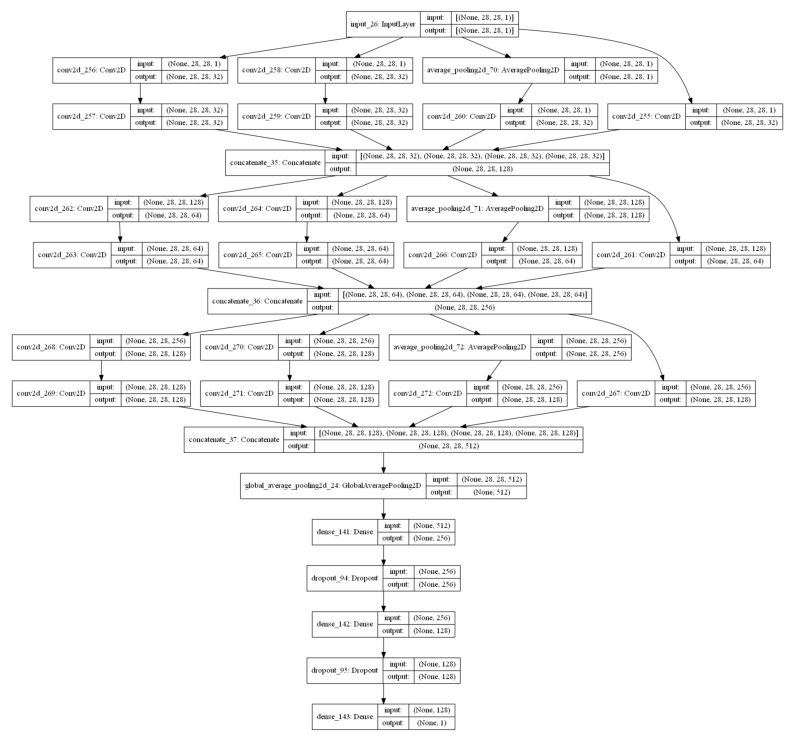

In [146]:
# Visualizzazione della struttura del modello
plot_model(cnn_inception_extended, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

# Mostra l'immagine della struttura del modello
img = plt.imread('model_structure.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

Si riporta anche per questa rete la sua struttura grafica, dove è possibile osservare i tre blocchi Inception in sequenza. 

## Data Augmentation sul miglior modello

A questo punto si è scelto di prendere il miglior modello trovato fino ad ora,e osservare il suo comportamento quando utilizzato in combinazione con la tencica della Data Augmentation.
<br>
L'idea in questo caso è quella di addestrare questo modello con una versione del dataset composta da immagini leggermente modificate rispetto a quelle originali, nella speranza che questo porti la rete a generalizzare meglio i dati, e avere prestazioni migliori sul testing set.

In [246]:
# Reshape dei dati di input
x_reshaped_train = x_train_images.reshape(-1, 28, 28, 1)
x_reshaped_valid = x_valid_images.reshape(-1, 28, 28, 1)
test_reshaped = test_images.reshape(-1, 28, 28, 1)

# Inizializzazione dei pesi
init = HeNormal(seed=42)

# Definizione della CNN
CNN_lenet_opt_da = Sequential([
    Conv2D(10, kernel_size=(5, 5), activation='relu',padding='same',input_shape=(28,28,1)),
    AveragePooling2D(pool_size=(2, 2),strides=2),        
    Dropout(0.35),
    Conv2D(20, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2),strides=2),
    Dropout(0.35),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer=init),
    Dropout(0.7),
    Dense(128, activation='relu', kernel_initializer=init),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])
# Compilazione del modello
CNN_lenet_opt_da.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Configurazione della Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=0,  # rotazione
    width_shift_range=0.05,  # Spostamento casuale orizzontale del 10% della larghezza
    height_shift_range=0.05,  # Spostamento casuale verticale del 10% dell'altezza
    zoom_range=0.05,  # Zoom casuale del 10%
    horizontal_flip=False,  # Ribaltamento casuale orizzontale
    vertical_flip=False  # Senza ribaltamento casuale verticale
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Addestramento del modello con Data Augmentation
history_CNN_lenet_opt_da = CNN_lenet_opt_da.fit(
    datagen.flow(x_reshaped_train, x_train_labels, batch_size=32),
    steps_per_epoch=len(x_reshaped_train) // 32,
    epochs=300,
    validation_data=(x_reshaped_valid, x_valid_labels),
    callbacks=[early_stopping]
)

Epoch 1/300
117/117 [==============================] - 2s 9ms/step - loss: 0.5722 - accuracy: 0.7294 - val_loss: 0.4562 - val_accuracy: 0.7487
Epoch 2/300
117/117 [==============================] - 1s 8ms/step - loss: 0.4045 - accuracy: 0.8101 - val_loss: 0.3071 - val_accuracy: 0.8929
Epoch 3/300
117/117 [==============================] - 1s 8ms/step - loss: 0.3091 - accuracy: 0.8730 - val_loss: 0.1795 - val_accuracy: 0.9343
Epoch 4/300
117/117 [==============================] - 1s 8ms/step - loss: 0.2606 - accuracy: 0.8904 - val_loss: 0.1907 - val_accuracy: 0.9311
Epoch 5/300
117/117 [==============================] - 1s 8ms/step - loss: 0.2431 - accuracy: 0.9022 - val_loss: 0.1770 - val_accuracy: 0.9343
Epoch 6/300
117/117 [==============================] - 1s 8ms/step - loss: 0.2317 - accuracy: 0.9127 - val_loss: 0.1491 - val_accuracy: 0.9459
Epoch 7/300
117/117 [==============================] - 1s 8ms/step - loss: 0.2209 - accuracy: 0.9135 - val_loss: 0.1290 - val_accuracy: 0.9459

In [247]:
# Valutazione del modello sui dati di test
_, CNN_lenet_opt_da_accuracy = CNN_lenet_opt_da.evaluate(test_reshaped, test_labels)
print('CNN_lenet_opt_da over test set = ', CNN_lenet_opt_da_accuracy)

y_pred_probs6 = cnn_inception_extended.predict(test_reshaped)
y_pred6 = (y_pred_probs6 > 0.5).astype(int).flatten()
y_true6 = test_labels.flatten()

# Calcolare l'F1 Score
f1_cnn_da = f1_score(y_true6, y_pred6)
print(f'F1 Score: {f1_cnn_da}')

# Calcolare la Confusion Matrix
cm_cnn_da = confusion_matrix(y_true6, y_pred6)

17/17 [==============================] - 0s 3ms/step - loss: 0.1005 - accuracy: 0.9656
CNN_lenet_opt_da over test set =  0.9656488299369812
F1 Score: 0.9833546734955185


La manipoliazione dei dati di addestramento non sembra essere però una tecnica efficace, riportando una accuracy sul testing set abbastanza bassa rispetto ai modelli precedenti. 
<br>
Questo è probabilmente dovuto anche alla natura delle immagini del dataset, che sono di natura medica. Infatti, osservando anche le immagini visualizzate nelle fasi preliminari di questo notebook è possibile vedere come il loro livello di zoom e di rotazione sia sempre estremamente simile. Questo è dovuto proprio alla natura scientifica delle immagini, che sono quindi realizzate in maniera rigorosa. 
<br>
Questo aspetto si riflette infatti anche sui milgiori parametri trovati per l'ImageDataGenerator: sono tutti valori che indicano trasformazioni minime delle immagini input originali. Andando ad alzare questi valori l'accuracy del modello scede ulteriormente. 
<br>
Probabilmente, su un dataset con immagini meno "standardizzate" questo approccio avrebbe portato a risultati migliori, aiutando la rete a generalizzare meglio. In questo caso invece è possibile che, andando a modificare le immagini per l'addestramento, si sia tolta alla rete la possibilità di imparare dei pattern che poi avrebbe ritrovato anche in fase di validazione/testing, data la natura scientifica delle immagini. Questo effetto potrebbe essere stato anche accentuato dalla (bassa) qualità delle immagini e dai pochi dettagli presenti al loro interno.

In [259]:
add_result_to_csv('CNN Lenet Dropout + DA', CNN_lenet_opt_da_accuracy)
add_result_to_csv('CNN Lenet Dropout + DA', f1_cnn_da, 'f1.csv')

## Analisi Risultati

Nella fase finale di quessto Notebook si vuole andare a confrontare le performance dei vari modelli.

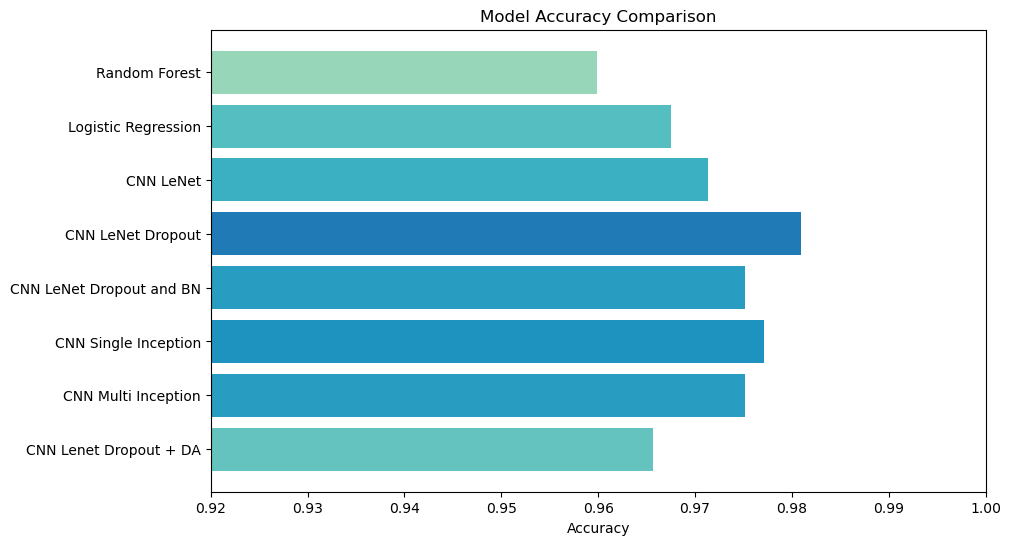

In [7]:
accuracies = []

models = ['Random Forest',
          'Logistic Regression',
          'CNN LeNet',
          'CNN LeNet Dropout',
          'CNN LeNet Dropout and BN',
          'CNN Single Inception',
          'CNN Multi Inception',
          'CNN Lenet Dropout + DA']

for model in models:
    accuracy = read_value_from_csv(model)
    accuracies.append(accuracy)

norm = Normalize(vmin=0.94, vmax=1.0)
colors = plt.cm.YlGnBu(norm(accuracies))# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.barh(models, accuracies, color=colors)
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0.92, 1.0)  # Limit the x-axis to better visualize differences
plt.gca().invert_yaxis()  # Invert y-axis to have the highest accuracy at the top
plt.show()

La prima metrica che si prende in considerazione è l'accuracy. 
<br>
Si può notare come Random Forest, che è stato il primo modello realizzato ed utilizzato come baseline, presenti un accuracy sensibilmente inferiore rispetto a tutti gli altri. 
<br>
Il modello che si comporta meglio è sicuramente CNN LeNet con Dropout, che è l'unico ad aver fatto registrare un'accuracy superioire al 98%. Ha avuto buone prestazioni rispetto a questa metrica anche la CNN con un singolo blocco inecption, che però presenta un numero di parametri più alto e tempi di addestramento più lunghi.  
Da notare anche come il modello con Data Augmentation (DA) abbia prestazioni peggiori di tutte le altre CNN, e anche più basse del modello di Regressione Logistica, che si comporta piuttosto bene per essere un modello più semplice rispetto alle reti neurali.
<br>
<br>
*Nota: la scala dell'accuracy è stata limitata all'intervallo* [0.92 - 1] *per esaltare le differenze tra i modelli, che sono così più evidenti.*

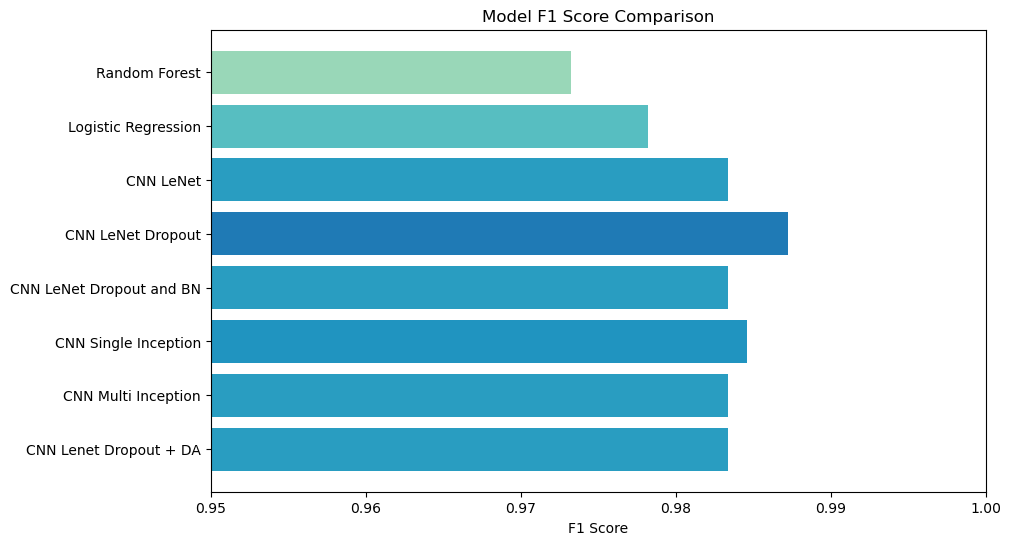

In [9]:
f1s = []
for model in models:
    f1 = read_value_from_csv(model, 'f1.csv')
    f1s.append(f1)

norm = Normalize(vmin=0.96, vmax=1.0)
colors = plt.cm.YlGnBu(norm(f1s))# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.barh(models, f1s, color=colors)
plt.xlabel('F1 Score')
plt.title('Model F1 Score Comparison')
plt.xlim(0.95, 1.0)  # Limit the x-axis to better visualize differences
plt.gca().invert_yaxis()  # Invert y-axis to have the highest accuracy at the top
plt.show()

Si procede ad analizzare anche i valori dell' F1-score per ogni modello. Si sceglie di utilizzare anche questa metrica per il confronto tra i vari modelli dato che si sta lavorando con un dataset sbilanciato. 

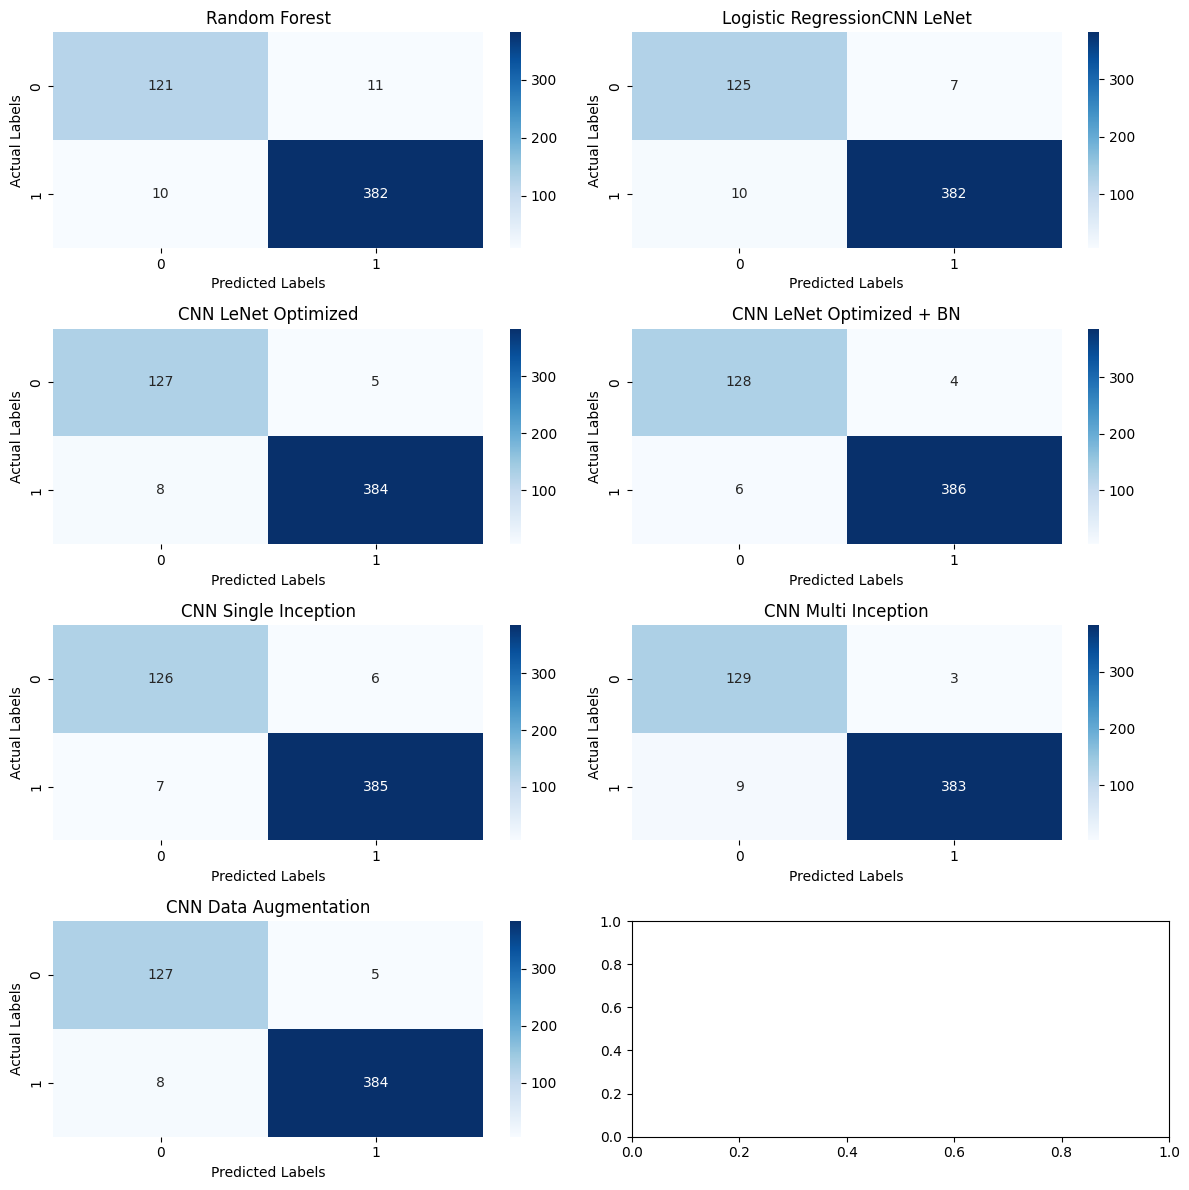

In [276]:

# Lista delle confusion matrix
cm_list = [cm_rf,
           cm_logreg,
           cm_cnn_lenet,
           cm_cnn_lenet_opt,
           cm_cnn_lenet_opt_bn,
           cm_cnn_single_inception,
           cm_cnn_multi_inception,
           cm_cnn_da]

# Numero di confusion matrix
n_cm = len(cm_list)

# Impostare la dimensione della figura e dei subplot
fig, axs = plt.subplots(n_cm // 2, 2, figsize=(12, 12))

# Iterare attraverso la lista di confusion matrix e visualizzarle
for i, (cm, title) in enumerate(zip(cm_list, models)):
    row = i // 2
    col = i % 2
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[row, col])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Predicted Labels')
    axs[row, col].set_ylabel('Actual Labels')

# Mostrare le confusion matrix
plt.tight_layout()
plt.show()